c:\Users\balas\anaconda3\envs\mango_disease_prediction\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\balas\anaconda3\envs\mango_disease_prediction\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\balas/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


Epoch 0/24, Train Loss: 1.0103, Val Loss: 1.7221, Val Acc: 0.4146
Epoch 1/24, Train Loss: 0.4102, Val Loss: 7.7499, Val Acc: 0.2683
Epoch 2/24, Train Loss: 0.3304, Val Loss: 5.8711, Val Acc: 0.3659
Epoch 3/24, Train Loss: 0.2021, Val Loss: 4.0103, Val Acc: 0.3902
Epoch 4/24, Train Loss: 0.2254, Val Loss: 2.1796, Val Acc: 0.6098
Epoch 5/24, Train Loss: 0.2615, Val Loss: 2.9954, Val Acc: 0.6341
Epoch 6/24, Train Loss: 0.2894, Val Loss: 5.7425, Val Acc: 0.5122
Epoch 7/24, Train Loss: 0.4095, Val Loss: 4.3949, Val Acc: 0.5366
Epoch 8/24, Train Loss: 0.2581, Val Loss: 2.6480, Val Acc: 0.6098
Epoch 9/24, Train Loss: 0.1425, Val Loss: 1.8820, Val Acc: 0.6829
Epoch 10/24, Train Loss: 0.3324, Val Loss: 0.9290, Val Acc: 0.6829
Epoch 11/24, Train Loss: 0.2800, Val Loss: 0.9397, Val Acc: 0.7561
Epoch 12/24, Train Loss: 0.2191, Val Loss: 1.6942, Val Acc: 0.6098
Epoch 13/24, Train Loss: 0.1883, Val Loss: 1.3047, Val Acc: 0.6585
Epoch 14/24, Train Loss: 0.2898, Val Loss: 1.8727, Val Acc: 0.4878
Epoch

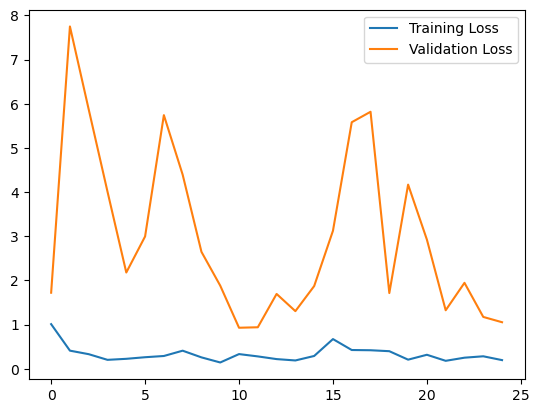

C:\Users\balas\AppData\Local\Temp\ipykernel_3412\2445199636.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Validation Accuracy: 0.7561
Predicted Class: Healthy


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet18
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image

# 1. Data Preparation
data_dir = r'D:\GAN PROJECT\DATASET\Training Data' 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 2. Model Definition
model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # 5 classes

# 3. Model Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 25
best_val_acc = 0.0
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_acc = corrects.double() / len(val_loader.dataset)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch}/{num_epochs-1}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Here We can Plot the Loss and Accuracy
plt.figure()
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.legend()
plt.show()

# 4. Model Evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

corrects = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)

val_acc = corrects.double() / len(val_loader.dataset)
print(f'Validation Accuracy: {val_acc:.4f}')

# 5. Prediction
def predict_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    return dataset.classes[preds[0]]

# Test the prediction function
test_image_path = r'D:\GAN PROJECT\DATASET\Testing Data\Healthy\healthy_109.jpg'  # Ensure the test image path is correct
print(f'Predicted Class: {predict_image(test_image_path)}')


In [3]:
test_image_path = r'D:\GAN PROJECT\DATASET\Testing Data\Healthy\healthy_109.jpg'  # Ensure the test image path is correct
print(f'Predicted Class: {predict_image(test_image_path)}')

Predicted Class: Healthy


NameError: name 'train_accuracies' is not defined

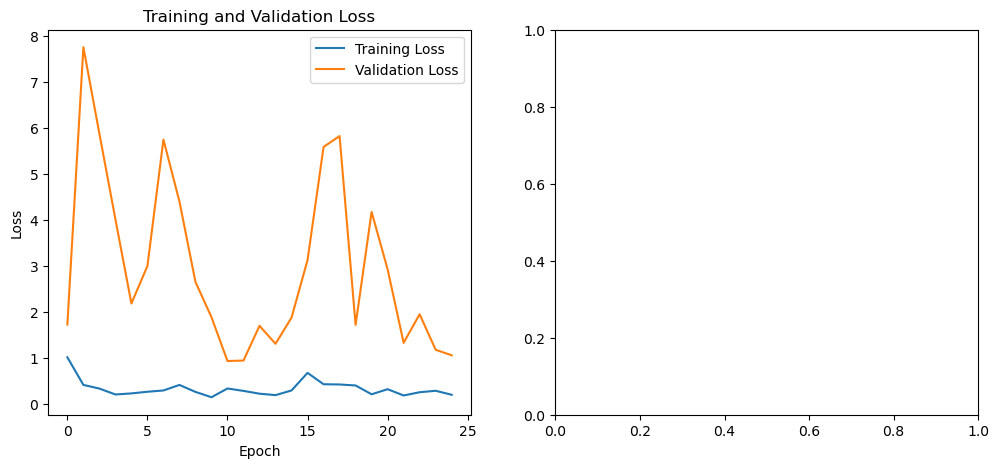

In [2]:
# Plot losses and accuracies
plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [5]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

corrects = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)

val_acc = corrects.double() / len(val_loader.dataset)
print(f'Validation Accuracy: {val_acc:.4f}')

# 5. Prediction
def predict_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    return dataset.classes[preds[0]]

test_image_path = r'd:\GAN PROJECT\DATASET\Testing Data\Black Mould Rot\aspergillus_138.jpg'  # Ensure the test image path is correct
print(f'Predicted Class: {predict_image(test_image_path)}')

C:\Users\balas\AppData\Local\Temp\ipykernel_3412\4079759776.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Validation Accuracy: 0.7561
Predicted Class: Black Mould Rot
